# Mechanism Model Analysis

## 1. Setup

In [1]:
#@title Import and Setup Onshape Client

!pip install onshape-client
from onshape_client.client import Client
from onshape_client.onshape_url import OnshapeElement
import json

#@markdown Chage the base if using an enterprise (i.e. "https://ptc.onshape.com")
base = 'https://cad.onshape.com' #@param {type:"string"}

#@markdown Would you like to import your API keys from a file, or copy and paste them directly?
keyImportOption = "Copy/Paste Keys" #@param ["Upload Keys from File", "Copy/Paste Keys"]

from IPython.display import clear_output 
clear_output()
print("Onshape Client successfully imported!")

if keyImportOption == "Upload Keys from File":
  from google.colab import files
  uploaded = files.upload()
  for fn in uploaded.keys():
    execfile(fn)

  client = Client(configuration={"base_url": base,
                                "access_key": access,
                                "secret_key": secret})
  clear_output()
  print('Onshape client configured - ready to go!')
else:
  access = input("Paste your Onshape Access Key: ")
  secret = input("Paste your Onshape Secret Key: ")
  client = Client(configuration={"base_url": base,
                                "access_key": access,
                                "secret_key": secret})
  clear_output()
  print('Onshape client configured - ready to go!')


Onshape client configured - ready to go!


In [42]:
#@title Get Assembly Definition
#@markdown Function `getAssemblyDefinition(url: str)` returns JSON of all parts in a document. The URL can be any element from the document.
url = 'https://cad.onshape.com/documents/83fe72223d6c66b41b765924/w/113e1197ad4a6fb4aa7ec89e/e/32213f4769260d44baa04f32' #@param {type:"string"}
showResponse = False#@param {type:"boolean"}
listParts = True#@param {type:"boolean"}
def getAssemblyDefinition(url: str):
  fixed_url = '/api/assemblies/d/did/w/wid/e/eid'

  element = OnshapeElement(url)
  fixed_url = fixed_url.replace('did', element.did)
  fixed_url = fixed_url.replace('wid', element.wvmid)
  fixed_url = fixed_url.replace('eid', element.eid)

  method = 'GET'

  params = {}
  payload = {}
  headers = {'Accept': 'application/vnd.onshape.v1+json; charset=UTF-8;qs=0.1',
            'Content-Type': 'application/json'}

  response = client.api_client.request(method, url=base + fixed_url, query_params=params, headers=headers, body=payload)

  parsed = json.loads(response.data)
  return parsed

assemblyDefinitionResponse = getAssemblyDefinition(url)

if showResponse:
  print(json.dumps(assemblyDefinitionResponse, indent=4, sort_keys=True))
if listParts:
  for instance in assemblyDefinitionResponse['rootAssembly']['instances']:
    name = instance['name']
    id = instance['id']
    print(f'Part named {name} has id {id}')
else:
  pass

Part named long <1> has id MVH0XKyf8KTYbGcUt
Part named short <1> has id MkDgRNuahZje4KFoa
Part named short <2> has id MryqLeLf3jqMe5AYq
Part named long <2> has id MA0u7AAFGH4ZEPP4F
Part named long <3> has id MIWdI457zLlmJ9qOb
Part named long <4> has id MLMsoSwF1nzM4G00L
Part named long <5> has id MfPJ2HUnqDkr4V6ln
Part named long <6> has id Me4F7q9AfegArwEDM
Part named short <3> has id MA2Cx0BIP8Vv/5AMQ
Part named short <4> has id MIlJtSmo55mzr5vwP
Part named base <1> has id MaeShPW47CUhd9/re
Part named end <1> has id MKx3zdFgIy1hymOfT
Part named end <2> has id M/DOa7cJLjEv6Tloh


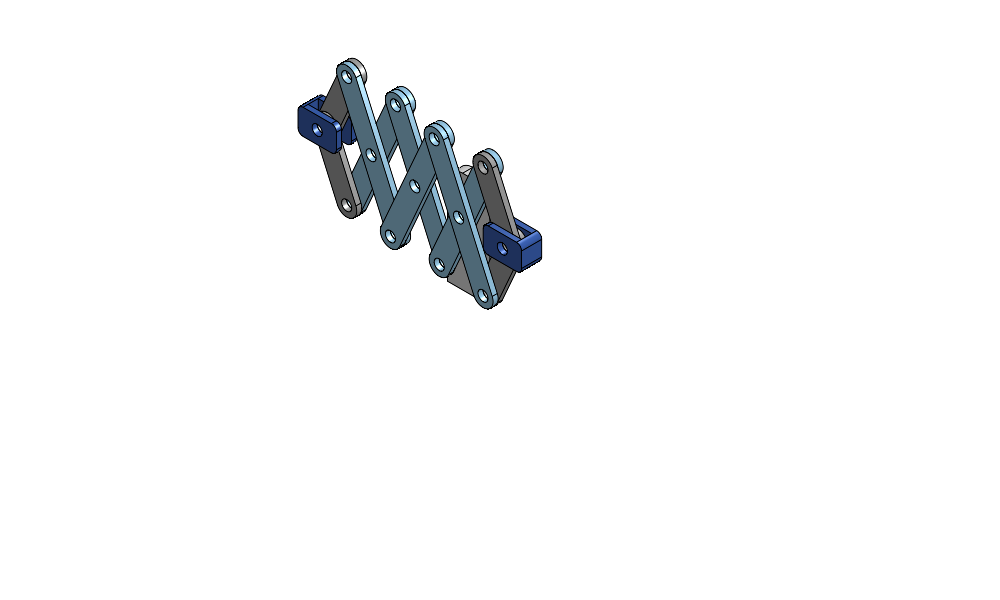

In [47]:
#@title Visualization

from onshape_client.oas import configuration

viewMatrix = "isometric" 
pixelSize = 0.0007

from IPython.display import Image
import base64

def partAssemblyShadedView(viewMatrix = "isometric",pixelSize = 0.003):
    # Returns the base64 image string of a shaded view of a part studio
    # viewMatrix can be any face direction or isometric as a string, or a 1x12 view matrix
    method = 'GET'
    fixed_url = '/api/assemblies/d/did/w/wid/e/eid'
    element = OnshapeElement(url)
    fixed_url = fixed_url.replace('did', element.did)
    fixed_url = fixed_url.replace('wid', element.wvmid)
    fixed_url = fixed_url.replace('eid', element.eid)

    if any(face in viewMatrix for face in ["front","back","top","bottom","left","right"]):
        matrix = viewMatrix
    elif viewMatrix == "isometric":
        matrix = "0.612,0.612,0,0,-0.354,0.354,0.707,0,0.707,-0.707,0.707,0"
    elif isinstance(viewMatrix,list):
        matrix = str(viewMatrix).replace('[','').replace(']','')
    else: 
        matrix = None 

    ## View Matrix below is roughly isometric
    params = {'viewMatrix':matrix,
                'edges':'show',
                'outputHeight':600,
                'outputWidth':1000,
                'pixelSize':pixelSize}
    
    payload = {}
    headers = {'Accept': 'application/vnd.onshape.v1+json',
                'Content-Type': 'application/json'}

    response = client.api_client.request(method, url=base + fixed_url + "/shadedviews", query_params=params, headers=headers, body=payload)
    
    parsed = json.loads(response.data)
    imgdata = base64.b64decode(parsed['images'][0])
    with open("image.jpg", 'wb') as f:
        f.write(imgdata)
    
    return imgdata

img = partAssemblyShadedView(viewMatrix,pixelSize)
display(Image(img))

## 2. Move Input of Mechanism

In [16]:
#@title Run this cell to load matrix helper functions

import math
import numpy

def IdentitySixteen():
  m = [
      1, 0, 0, 0,
      0, 1, 0, 0,
      0, 0, 1, 0,
      0, 0, 0, 1
      ]
  return m

def DiceTransform(value):
    switcher = {
        0: [
            0, 0, 1, 0,
            0, 1, 0, 0,
            -1, 0, 0, 0,
            0, 0, 0, 1
           ],
        1: [
            0, 0, 1, 0,
            0, 1, 0, 0,
            -1, 0, 0, 0,
            0, 0, 0, 1
           ],
        2: [
            1, 0, 0, 0,
            0, 0, 1, 0,
            0, -1, 0, 0,
            0, 0, 0, 1
           ],
        3: [
            1, 0, 0, 0,
            0, -1, 0, 0,
            0, 0, -1, 0,
            0, 0, 0, 1
           ],
        4: [
            1, 0, 0, 0,
            0, 1, 0, 0,
            0, 0, 1, 0,
            0, 0, 0, 1
           ],
        5: [
            1, 0, 0, 0,
            0, 0, -1, 0,
            0, 1, 0, 0,
            0, 0, 0, 1
           ],
        6: [
            0, 0, -1, 0,
            0, 1, 0, 0,
            1, 0, 0, 0,
            0, 0, 0, 1
           ] 
    }
  
    # get() method of dictionary data type returns 
    # value of passed argument if it is present 
    # in dictionary otherwise second argument will
    # be assigned as default value of passed argument
    return switcher.get(value, "nothing")

def DiceMove(value,x1,y1):
  matrix = DiceTransform(value)
  matrix[3] = x1
  matrix[7] = y1
  return matrix

def DiceFollow(diceMatrix,tcpMatrix):
  diceMatrix[3] = tcpMatrix[3]
  diceMatrix[7] = tcpMatrix[7]
  diceMatrix[11] = tcpMatrix[11]
  return diceMatrix
  
def sixteenToFourByFour(matrix):
  fourbyfour = [[matrix[0],matrix[1],matrix[2],matrix[3]],
                [matrix[4],matrix[5],matrix[6],matrix[7]],
                [matrix[8],matrix[9],matrix[10],matrix[11]],
                [matrix[12],matrix[13],matrix[14],matrix[15]]]
  return fourbyfour

def fourByFourToSixteen(matrix):
  sixteen = [matrix[0][0],matrix[0][1],matrix[0][2],matrix[0][3],
             matrix[1][0],matrix[1][1],matrix[1][2],matrix[1][3],
             matrix[2][0],matrix[2][1],matrix[2][2],matrix[2][3],
             matrix[3][0],matrix[3][1],matrix[3][2],matrix[3][3]]
  return sixteen

def clockwiseSpinX(theta):
  m = [[1, 0, 0, 0],
       [0, math.cos(theta), math.sin(theta), 0],
       [0, -math.sin(theta), math.cos(theta), 0],
       [0, 0, 0, 1]
       ]
  return m

def clockwiseSpinY(theta):
  m = [[math.cos(theta), 0, math.sin(theta), 0],
       [0, 1, 0, 0],
       [-math.sin(theta), 0, math.cos(theta), 0],
       [0, 0, 0, 1]
       ]
  return m

def clockwiseSpinZ(theta):
  m = [[math.cos(theta), math.sin(theta), 0, 0],
       [-math.sin(theta), math.cos(theta), 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]]
  return m


In [48]:
#@title Transformation Matrix
#@markdown Move the part with specified id. (Use getAssemblyDefinition function to get part IDs)
url = 'https://cad.onshape.com/documents/83fe72223d6c66b41b765924/w/113e1197ad4a6fb4aa7ec89e/e/32213f4769260d44baa04f32' #@param {type:"string"}
partIdToMove = 'MKx3zdFgIy1hymOfT'#@param {type:'string'}
isRelative = True#@param {type:'boolean'}
#@markdown Translate object to x1,y1,z1 (if isRelative is False) or by x1,y1,z1 in the x,y,z directions (if isRelative is True)
x1 = 0.001#@param
y1 = 0#@param
z1 = 0#@param

occurrences = getAssemblyDefinition(url)['rootAssembly']['occurrences']
for x in occurrences:
    if x['path'][0] == partIdToMove:
      occurrence = x
## Reset the transformation matrix
occurrence['transform'] = IdentitySixteen()
occurrence['transform'][3] = x1
occurrence['transform'][7] = y1
occurrence['transform'][11] = z1

## Put translation first, rotation second to rotate about global coordinate system first
print("Transformation matrix:")
for x in sixteenToFourByFour(occurrence['transform']):
  print(x)
      
## Send assembly occurence transforms
fixed_url = '/api/assemblies/d/did/w/wid/e/eid/occurrencetransforms'

element = OnshapeElement(url)
fixed_url = fixed_url.replace('did', element.did)
fixed_url = fixed_url.replace('wid', element.wvmid)
fixed_url = fixed_url.replace('eid', element.eid)

method = 'POST'

params = {}

payload = {'isRelative':isRelative,
           'occurrences':[occurrence],
           'transform':occurrence['transform']
    }

headers = {'Accept': 'application/vnd.onshape.v1+json; charset=UTF-8;qs=0.1',
           'Content-Type': 'application/json'}

response = client.api_client.request(method, url=base + fixed_url, query_params=params, headers=headers, body=payload)

Transformation matrix:
[1, 0, 0, 0.001]
[0, 1, 0, 0]
[0, 0, 1, 0]
[0, 0, 0, 1]


## 3. Test Input & Output Positions

In [49]:
url = 'https://cad.onshape.com/documents/83fe72223d6c66b41b765924/w/113e1197ad4a6fb4aa7ec89e/e/32213f4769260d44baa04f32' #@param{'type': 'string'}
input_partId = 'MKx3zdFgIy1hymOfT' #@param{'type': 'string'}

method = "GET"
headers = {'Accept': 'application/vnd.onshape.v2+json;charset=UTF-8;qs=0.2',
           'Content-Type': 'application/json'}
params = {}
payload = {} 

fixed_url = '/api/assemblies/d/did/w/wid/e/eid'
element = OnshapeElement(url)
fixed_url = fixed_url.replace('did', element.did)
fixed_url = fixed_url.replace('wid', element.wvmid)
fixed_url = fixed_url.replace('eid', element.eid)

response = client.api_client.request(method=method, url=base + fixed_url, query_params=params, headers=headers, body=payload)
parsed  = json.loads(response.data)

for occ in parsed['rootAssembly']['occurrences']: 
    if occ['path'][0] == input_partId: 
        # print(json.dumps(occ, indent=4))
        print("X Pos:", occ['transform'][3])
        print("Y Pos:", occ['transform'][7])


X Pos: 0.08831602095189425
Y Pos: -0.005000000000000137


In [50]:
url = 'https://cad.onshape.com/documents/83fe72223d6c66b41b765924/w/113e1197ad4a6fb4aa7ec89e/e/32213f4769260d44baa04f32' #@param{'type': 'string'}
output_partId = 'M/DOa7cJLjEv6Tloh' #@param{'type': 'string'}

method = "GET"
headers = {'Accept': 'application/vnd.onshape.v2+json;charset=UTF-8;qs=0.2',
           'Content-Type': 'application/json'}
params = {}
payload = {} 

fixed_url = '/api/assemblies/d/did/w/wid/e/eid'
element = OnshapeElement(url)
fixed_url = fixed_url.replace('did', element.did)
fixed_url = fixed_url.replace('wid', element.wvmid)
fixed_url = fixed_url.replace('eid', element.eid)

response = client.api_client.request(method=method, url=base + fixed_url, query_params=params, headers=headers, body=payload)
parsed  = json.loads(response.data)

for occ in parsed['rootAssembly']['occurrences']: 
    if occ['path'][0] == output_partId: 
        # print(json.dumps(occ, indent=4))
        print("X Pos:", occ['transform'][3])
        print("Y Pos:", occ['transform'][7])


X Pos: -0.2289480628556616
Y Pos: -0.01500000000000002


## Putting it all together

In [59]:
#@title Run this cell to load kinematics and definitons functions
#@markdown Translation Configurations

import numpy as np 

# Function: Get assembly definition
def getAssemblyDefinition(url: str):
  fixed_url = '/api/assemblies/d/did/w/wid/e/eid'
  element = OnshapeElement(url)
  base = element.base_url
  fixed_url = fixed_url.replace('did', element.did)
  fixed_url = fixed_url.replace('wid', element.wvmid)
  fixed_url = fixed_url.replace('eid', element.eid)

  method = 'GET'
  params = {}
  payload = {}
  headers = {'Accept': 'application/vnd.onshape.v1+json; charset=UTF-8;qs=0.1',
            'Content-Type': 'application/json'}

  response = client.api_client.request(method, url=base + fixed_url, query_params=params, headers=headers, body=payload)
  parsed = json.loads(response.data)
  return parsed

# Function: Translate input
def translate_input(url, assembly, partId: str, translation: float):
  url = 'https://cad.onshape.com/documents/83fe72223d6c66b41b765924/w/113e1197ad4a6fb4aa7ec89e/e/32213f4769260d44baa04f32' #@param {type:"string"}
  partIdToMove = 'MKx3zdFgIy1hymOfT'#@param {type:'string'}
  isRelative = True#@param {type:'boolean'}
  #@markdown Translate object to x1,y1,z1 (if isRelative is False) or by x1,y1,z1 in the x,y,z directions (if isRelative is True)
  x1 = 0.01#@param
  y1 = 0#@param
  z1 = 0#@param

  occurrences = getAssemblyDefinition(url)['rootAssembly']['occurrences']
  for x in occurrences:
      if x['path'][0] == partIdToMove:
        occurrence = x
  ## Reset the transformation matrix
  occurrence['transform'] = IdentitySixteen()
  occurrence['transform'][3] = x1
  occurrence['transform'][7] = y1
  occurrence['transform'][11] = z1
        
  ## Send assembly occurence transforms
  fixed_url = '/api/assemblies/d/did/w/wid/e/eid/occurrencetransforms'

  element = OnshapeElement(url)
  fixed_url = fixed_url.replace('did', element.did)
  fixed_url = fixed_url.replace('wid', element.wvmid)
  fixed_url = fixed_url.replace('eid', element.eid)

  method = 'POST'

  params = {}

  payload = {'isRelative':isRelative,
            'occurrences':[occurrence],
            'transform':occurrence['transform']
      }

  headers = {'Accept': 'application/vnd.onshape.v1+json; charset=UTF-8;qs=0.1',
            'Content-Type': 'application/json'}

  response = client.api_client.request(method, url=base + fixed_url, query_params=params, headers=headers, body=payload)

# Function: Get position information for part (sync)
def get_position(assembly, partId: str):
  for occ in assembly['rootAssembly']['occurrences']: 
    if occ['path'][0] == partId: 
        return occ['transform'][3], occ['transform'][7]
  print("Part not found!") 
  return None 

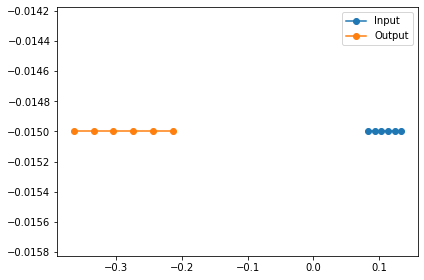

In [60]:
import matplotlib.pyplot as plt

# Store position values
input_partId = 'MKx3zdFgIy1hymOfT' #@param{'type': 'string'}
output_partId = 'M/DOa7cJLjEv6Tloh' #@param{'type': 'string'}

input_x_pos = [] 
input_y_pos = [] 
output_x_pos = [] 
output_y_pos = [] 

step =  5#@param{'type': 'number'}

assembly_info = getAssemblyDefinition(url)
in_pos = get_position(assembly_info, input_partId) # CHANGE 
out_pos = get_position(assembly_info, output_partId) # CHANGE 
if in_pos and out_pos: 
    input_x_pos.append(in_pos[0])
    input_y_pos.append(in_pos[1])
    output_x_pos.append(out_pos[0])
    output_y_pos.append(out_pos[1])
    for i in range(step): 
        translate_input(url, assembly_info, input_partId, step) 
        assembly_info = getAssemblyDefinition(url)
        in_pos = get_position(assembly_info, input_partId) 
        out_pos = get_position(assembly_info, output_partId) 
        input_x_pos.append(in_pos[0])
        input_y_pos.append(in_pos[1])
        output_x_pos.append(out_pos[0])
        output_y_pos.append(out_pos[1])

# Plot the position path 
# print(input_x_pos)
# print(input_y_pos)
# print(output_x_pos)
# print(output_y_pos)

# Constraint
input_y_pos = output_y_pos

fig, ax = plt.subplots()
ax.plot(input_x_pos, input_y_pos, label='Input', marker='o')
ax.plot(output_x_pos, output_y_pos, label='Output', marker='o')

plt.legend()
plt.tight_layout()
plt.show()